In [1]:
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
import scipy
import scipy.ndimage
import scipy.spatial
import torch.nn as nn

# Introduction

In this notebook I provide a step-by-step example of a forward pass for a single PASCAL VOC 2012 image using baseline ConvNet and GNN models as well as using our improved GNNs with: 
1. hierarchical relations
2. learnable relations
3. multiscale filters
4. advanced relation fusion methods

See our BMVC 2019 paper on [Image Classification with Hierarchical Multigraph Networks](https://arxiv.org/abs/1907.09000) for more details.

# 1. Load the image

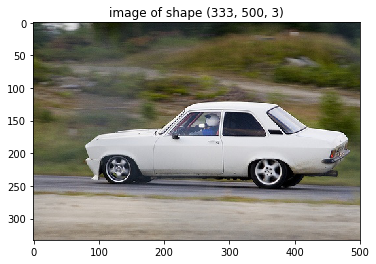

In [2]:
img = np.array(Image.open('2007_007948.jpg'))
img = (img / float(img.max())).astype(np.float32)
plt.imshow(img)
plt.title('image of shape {}'.format(img.shape))
plt.show()

# 2. Preprocess the image

## 2.1. Prepare the input for a ConvNet

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


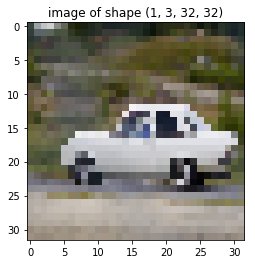

In [3]:
img_convnet = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
img_convnet = torch.nn.functional.interpolate(img_convnet, size=(32, 32), mode='bilinear')
plt.imshow(img_convnet.squeeze().permute(1, 2, 0).data.numpy())
plt.title('image of shape {}'.format(tuple(img_convnet.shape)))
plt.show()

## 2.2. Prepare the spatial graph for a GNN

C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]

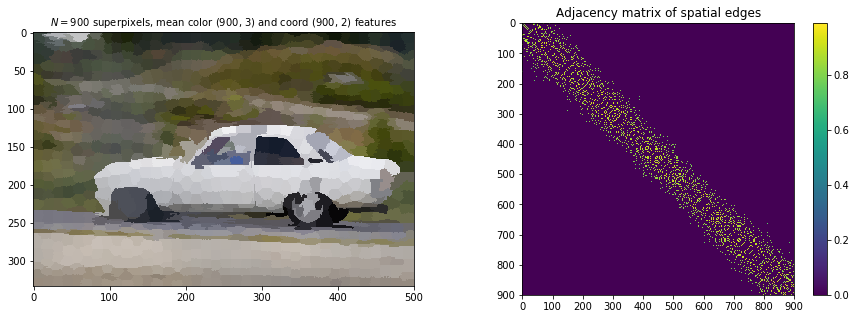

In [4]:
knn_graph=32

def sparsify_graph(A, knn_graph):
    if knn_graph is not None and knn_graph < A.shape[0]:
        idx = np.argsort(A, axis=0)[:-knn_graph, :]
        np.put_along_axis(A, idx, 0, axis=0)
        idx = np.argsort(A, axis=1)[:, :-knn_graph]
        np.put_along_axis(A, idx, 0, axis=1)
    return A    
        
def spatial_graph(coord, img_size, knn_graph=32):
    coord = coord / np.array(img_size, np.float)
    dist = cdist(coord, coord)
    sigma = 0.1 * np.pi
    A = np.exp(- dist / sigma**2)
    A[np.diag_indices_from(A)] = 0  # remove self-loops
    sparsify_graph(A, knn_graph)
    return A  # adjacency matrix (edges)

def visualize_superpixels(avg_values, superpixels):
    n_ch = avg_values.shape[1]
    img_sp = np.zeros((*superpixels.shape, n_ch))
    for sp in np.unique(superpixels):
        mask = superpixels == sp
        for c in range(n_ch):
            img_sp[:, :, c][mask] = avg_values[sp, c]
    return img_sp

def superpixel_features(img, superpixels):
    n_sp = len(np.unique(superpixels))
    n_ch = img.shape[2]
    avg_values = np.zeros((n_sp, n_ch))
    coord = np.zeros((n_sp, 2))
    masks = []
    for sp in np.unique(superpixels):
        mask = superpixels == sp
        for c in range(n_ch):
            avg_values[sp, c] = np.mean(img[:, :, c][mask])         
        coord[sp] = np.array(scipy.ndimage.measurements.center_of_mass(mask))  # row, col
        masks.append(mask)
    return avg_values, coord, masks

superpixels = slic(img, n_segments=1000)
avg_values, coord, masks = superpixel_features(img, superpixels)
A_spatial = spatial_graph(coord, img.shape[:2], knn_graph=knn_graph)  # keep only 16 neighbors for each node
img_sp = visualize_superpixels(avg_values, superpixels)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(img_sp)
plt.title('$N=${} superpixels, mean color {} and coord {} features'.format(len(np.unique(superpixels)), 
                                                                           avg_values.shape,
                                                                           coord.shape), fontsize=10)
plt.subplot(122)
plt.imshow(A_spatial ** 0.2)
plt.colorbar()
plt.title('Adjacency matrix of spatial edges')
plt.show()

## 2.3. Prepare the hierarchical graph for a GNN

C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\segmentation\slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]

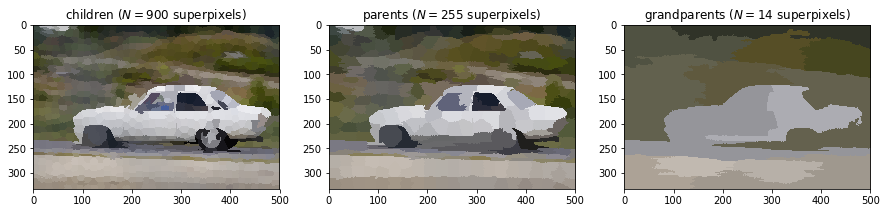

2.6% nonzero edges in the spatial multiscale graph
0.5% nonzero edges in the hierarchical graph


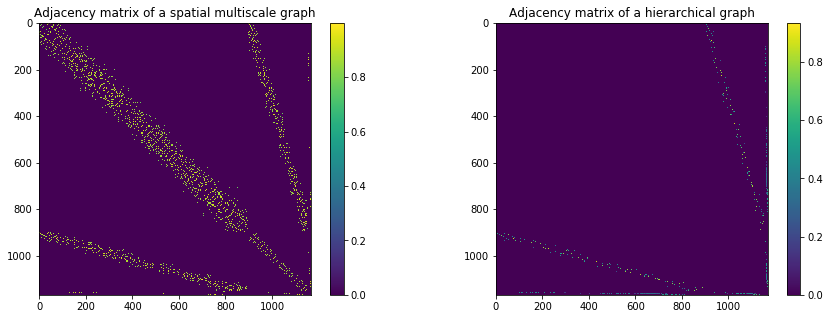

In [5]:
def compute_iou_binary(seg1, seg2):
    inters = float(np.count_nonzero(seg1 & seg2))
    # areas can be precomputed in advance
    seg1_area = float(np.count_nonzero(seg1))
    seg2_area = float(np.count_nonzero(seg2))
    return inters / (seg1_area + seg2_area - inters)

def hierarchical_graph(masks_multiscale, n_sp_actual, knn_graph=32):
    n_sp_total = np.sum(n_sp_actual)
    A = np.zeros((n_sp_total, n_sp_total))
    for level1, masks1 in enumerate(masks_multiscale):
        for level2, masks2 in enumerate(masks_multiscale[level1+1:]):
            for i, mask1 in enumerate(masks1):
                for j, mask2 in enumerate(masks2):
                    A[np.sum(n_sp_actual[:level1], dtype=np.int) + i, np.sum(n_sp_actual[:level2+level1+1], dtype=np.int) + j] = compute_iou_binary(mask1, mask2)
    sparsify_graph(A, knn_graph)
    return A + A.T

fig, axes = plt.subplots(1, 3, figsize=(15,7))
n_sp_actual = []
avg_values_multiscale, coord_multiscale, masks_multiscale = [], [], []

# Scales [1000, 300, 150, 75, 21, 7] in the paper
for i, (name, sp) in enumerate(zip(['children', 'parents', 'grandparents'], [1000, 300, 21])):
    superpixels = slic(img, n_segments=sp)
    n_sp_actual.append(len(np.unique(superpixels)))
    avg_values_, coord_, masks_ = superpixel_features(img, superpixels)
    avg_values_multiscale.append(avg_values_)
    coord_multiscale.append(coord_)
    masks_multiscale.append(masks_)
    axes[i].set_title('{} ($N=${} superpixels)'.format(name, n_sp_actual[i]))
    axes[i].imshow(visualize_superpixels(avg_values_, superpixels))
plt.show()

A_spatial_multiscale = spatial_graph(np.concatenate(coord_multiscale), img.shape[:2], knn_graph=knn_graph)
A_hier = hierarchical_graph(masks_multiscale, n_sp_actual, knn_graph=None)
print('{:.1f}% nonzero edges in the spatial multiscale graph'.format( 
    100 * np.sum(A_spatial_multiscale > 0) / (np.prod(A_spatial_multiscale.shape))))
print('{:.1f}% nonzero edges in the hierarchical graph'.format( 
    100 * np.sum(A_hier > 0) / (np.prod(A_hier.shape))))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(A_spatial_multiscale ** 0.2)
plt.colorbar()
plt.title('Adjacency matrix of a spatial multiscale graph')
plt.subplot(122)
plt.imshow(A_hier ** 0.2)
plt.colorbar()
plt.title('Adjacency matrix of a hierarchical graph')
plt.show()

# 3. ConvNet baseline

In [6]:
# compute the number of trainable parameters
num_params = lambda model: np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()])

## 3.1. Define a ConvNet model

In [7]:
class ConvNet(nn.Module):
    def __init__(self,
                 in_features=3,
                 n_classes=20,
                 filters=[32,64,512],
                 kernel_sizes=[5,3,3],
                 bnorm=True):
        super(ConvNet, self).__init__()
        conv_layers = []
        for layer, (f, ks) in enumerate(zip(filters, kernel_sizes)):
            conv_layers.append(nn.Conv2d(in_features if layer == 0 else filters[layer - 1], f, 
                                         kernel_size=ks, stride=1, padding=(ks - 1) // 2))
            if bnorm:
                conv_layers.append(nn.BatchNorm2d(f))
            conv_layers.append(nn.ReLU(True))
            if layer < len(filters) - 1:
                conv_layers.append(nn.MaxPool2d(2))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.fc = nn.Linear(filters[-1], n_classes)

    def forward(self, data):
        x = self.conv_layers(data)  # B,W,H,out_features
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1)  # Global AVG pooling
        x = x.view(x.size(0), -1)
        return self.fc(x)  # classification

## 3.2. Forward pass to a ConvNet

32.69% on PASCAL

In [8]:
model = ConvNet()
print(model)
print('number of trainable params: %d' % num_params(model))
predictions = model(img_convnet)  # we can feed coordinates of each pixel here as in GNNs, but it won't help
print('predictions for %d classes:' % predictions.shape[1], predictions.shape)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc): Linear(in_features=512, out_features=20, bias=True)
)
number of trainable params: 327828
predictions for 20 classes: torch.Size([1, 20])


# 4. Graph Neural Network baseline

## 4.1. Define a Graph Convolution layer

In [9]:
class BatchNorm1d_GNN(nn.BatchNorm1d):
    '''To make batch normalization over features'''
    def __init__(self, num_features):
        super(BatchNorm1d_GNN, self).__init__(num_features)
        
    def forward(self, x):
        return super(BatchNorm1d_GNN, self).forward(x.permute(0, 2, 1)).permute(0, 2, 1)

class GraphLayer(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 K,
                 bnorm=True,
                 activation=nn.ReLU(True),
                 n_relations=1):
        super(GraphLayer, self).__init__()
        assert K > 0, 'order is assumed to be > 0'
        self.K = K
        self.bnorm = bnorm
        self.n_relations = n_relations
        fc = [nn.Linear(in_features * K * n_relations, out_features)]
        if bnorm:
            fc.append(BatchNorm1d_GNN(out_features))
        if activation is not None:
            fc.append(activation)
        self.fc = nn.Sequential(*fc)

    def chebyshev_basis(self, L, X, K):
        if K > 1:
            # ChebyNet
            Xt = [X]
            Xt.append(torch.bmm(L, X))  # B,N,F
            for k in range(2, K):
                Xt.append(2 * torch.bmm(L, Xt[k - 1]) - Xt[k - 2])  # B,N,F
            Xt = torch.stack(Xt, 2)  # B,N,K,F
            return Xt
        else:
            # GCN
            assert K == 1, K
            return torch.bmm(L, X).unsqueeze(2)  # B,N,1,F

    def laplacian_batch(self, A, add_identity=False):
        '''
        Computes normalized Laplacian transformed so that its eigenvalues are in range [-1, 1].
        A can be a multirelational matrix.
        '''
        B, N = A.shape[:2]
        if add_identity:
            A = A + torch.eye(N, device=A.get_device() if A.is_cuda else 'cpu').unsqueeze(0).unsqueeze(3)
        D = torch.sum(A, 1)  # nodes degree (B,N,R)
        D_hat = (D + 1e-5) ** (-0.5)
        L = D_hat.view(B, N, 1, -1) * A * D_hat.view(B, 1, N, -1)  # B,N,N,R
        return L if add_identity else -L  # for a valid Chebyshev basis

    def relation_fusion(self, x, A):
        y = []
        B, N = x.shape[:2]
        for rel in range(self.n_relations):
            y.append(self.chebyshev_basis(A[:, :, :, rel], x, self.K))  # B,N,K,C
        y = self.fc(torch.cat(y, 2).view(B, N, -1))  # B,N,F
        return y
    
    def forward(self, data):
        x, A, is_Laplacian = data[:3]
        B, N, C = x.shape
        if len(A.shape) == 3:
            A = A.unsqueeze(3)
        if not is_Laplacian:
            # can be done during preprocessing (except for the learnable graph)
            A = self.laplacian_batch(A, add_identity=self.K == 1)
        y = self.relation_fusion(x, A)
        
        return [y, A, True]  # return Laplacian to avoid computing it again

## 4.2. Define a GNN model

In [10]:
class GNN(nn.Module):
    '''
    Graph Neural Network class.
    '''
    def __init__(self,
                 in_features=5,
                 n_classes=20,
                 filters=[32, 64, 512],
                 K=1,
                 n_relations=1):
        super(GNN, self).__init__()
        graph_layers = []
        for layer, f in enumerate(filters):
            graph_layers.append(GraphLayer(in_features if layer == 0 else filters[layer - 1], f, K, 
                                           n_relations=n_relations))
            
        self.graph_layers = nn.Sequential(*graph_layers)
        self.fc = nn.Linear(filters[-1], n_classes)

    def forward(self, data):
        x = self.graph_layers(data)[0]  # B,N,out_features
        x = torch.max(x, dim=1)[0]  # Global MAX pooling
        return self.fc(x)  # classification

## 4.3. Forward pass to a GNN

19.24% on PASCAL

In [11]:
model = GNN()
print(model)
print('number of trainable params: %d' % num_params(model))
data = [torch.from_numpy(np.concatenate((coord, avg_values), axis=1)).unsqueeze(0).float(), 
        torch.from_numpy(A_spatial).unsqueeze(0).float(), False]
predictions = model(data)
print('predictions for %d classes:' % predictions.shape[1], predictions.shape)

GNN(
  (graph_layers): Sequential(
    (0): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=5, out_features=32, bias=True)
        (1): BatchNorm1d_GNN(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (1): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=64, bias=True)
        (1): BatchNorm1d_GNN(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (2): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): BatchNorm1d_GNN(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=20, bias=True)
)
number of trainable params: 47060
predictions for 20 classes: torch.Size([1, 20])


# 5. Improve the GNN baseline

## 5.1. Improvement #1 - Hierarchial GNN

31.65% on PASCAL

In [12]:
model = GNN(n_relations=2)
print(model)
print('number of trainable params: %d' % num_params(model))
data = [torch.from_numpy(np.concatenate((np.concatenate(coord_multiscale), 
                                         np.concatenate(avg_values_multiscale)), axis=1)).unsqueeze(0).float(), 
        torch.from_numpy(np.stack((A_spatial_multiscale, A_hier), axis=2)).unsqueeze(0).float(), False]
predictions = model(data)
print('predictions for %d classes:' % predictions.shape[1], predictions.shape)

GNN(
  (graph_layers): Sequential(
    (0): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=10, out_features=32, bias=True)
        (1): BatchNorm1d_GNN(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (1): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d_GNN(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (2): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): BatchNorm1d_GNN(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
  )
  (fc): Linear(in_features=512, out_features=20, bias=True)
)
number of trainable params: 82036
predictions for 20 classes: torch.Size([1, 20])


## 5.2. Improvement #2 - Hierarchial GNN with learnable relations

31.21% on PASCAL (worse here than just hierarchical relations, but better in other cases and other datasets)

In [13]:
class LearnableGraph(nn.Module):
    '''The network that learns to predict an adjacency matrix'''
    def __init__(self,
                 in_features=2,
                 n_hidden=32,
                 out_features=1,
                 neigborhood_ratio=0.2):
        super(LearnableGraph, self).__init__()
        self.out_features = out_features
        self.neigborhood_ratio = neigborhood_ratio
        self.pred_edge = nn.Sequential(nn.Linear(in_features, n_hidden),
                                       nn.ReLU(True),
                                       nn.Linear(n_hidden, out_features))

#     # to test that it predicts for correct positions in the adjacency matrix
#     def pred_edge(self, data):
#         return torch.ones(data.shape[0], 1)
    
    def forward(self, coord, A_spatial):
        B, N, C = coord.shape
        node_i = torch.from_numpy(np.repeat(np.arange(N), N)).long()
        node_j = torch.from_numpy(np.tile(np.arange(N), N)).long()
        
        triu = np.triu_indices(N)
        A_spatial_triu = A_spatial.clone()
        
        knn_graph = int(self.neigborhood_ratio * N)
        features, indices_edges = [], []
        # collect pairs of node features
        for b in range(B):
            A_spatial_triu[b, triu[0], triu[1]] = 0  # make predictions only for a lower triangle of a matrix
            if knn_graph < N:
                idx = torch.sort(A_spatial_triu[b], dim=0, descending=False)[1][:-knn_graph, :]
                A_spatial_triu[b].scatter_(0, idx, 0)
                idx = torch.sort(A_spatial_triu[b], dim=1, descending=False)[1][:, :-knn_graph]
                A_spatial_triu[b].scatter_(1, idx, 0)
            plt.imshow((A_spatial_triu[b] > 0).view(N, N).data.numpy())
            plt.colorbar()
            plt.title('%d edges to be predicted' % torch.sum(A_spatial_triu[b] > 0))
            plt.show()
            ind_edges = torch.nonzero(A_spatial_triu[b] > 0)  # k,N
            if len(ind_edges) > 0:
                ind_edges = ind_edges[:, 0] * N + ind_edges[:, 1]
                features.append(coord[b, node_i[ind_edges], :] - coord[b, node_j[ind_edges], :])
            indices_edges.append(ind_edges)
            
        A_learned = A_spatial.new(B, N * N, self.out_features).fill_(0)
        if len(features) > 0:
            y = torch.exp(self.pred_edge(torch.abs(torch.cat(features, dim=0))))  # make predictions
            n = 0
            for b in range(B):
                n1 = len(indices_edges[b])
                if n1 > 0:
                    A_learned[b, indices_edges[b], :] = y[n:n + n1, :]
                    n += n1
        A_learned = A_learned.view(B, N, N)
        A_learned = A_learned + A_learned.permute(0, 2, 1)  # add symmetric edges
        return A_learned

    
class LearnableGNN(nn.Module):
    '''
    Graph Neural Network with learnable edges.
    '''
    def __init__(self,
                 in_features=5,
                 n_classes=20,
                 filters=[32, 64, 512],
                 K=1,
                 n_relations=2,
                 neigborhood_ratio=0.2,
                 graph_layer=GraphLayer):
        super(LearnableGNN, self).__init__()
        self.K = K
        graph_layers = []
        for layer, f in enumerate(filters):
            graph_layers.append(graph_layer(in_features if layer == 0 else filters[layer - 1], f, K, 
                                            n_relations=n_relations))
            
        self.graph_layers = nn.Sequential(*graph_layers)
        self.pred_edge = LearnableGraph(neigborhood_ratio=neigborhood_ratio)
        self.fc = nn.Linear(filters[-1], n_classes)

    def forward(self, data):
        x, A = data[:2]
        if len(A.shape) == 3:
            A = A.unsqueeze(3)
        A_learned = self.pred_edge(x[:, :, :2], A[:, :, :, 0])
        A = torch.cat((A, A_learned.unsqueeze(3)), dim=3)
        fig, axes = plt.subplots(1, 3, figsize=(15,5))
        names = ['spatial', 'hierarchical', 'learned']
        for rel in range(A.shape[3]):
            axes[rel].imshow(np.linalg.matrix_power(A[0, :, :, rel].data.numpy(), self.K) ** 0.2)
#             axes[rel].imshow((A[0, :, :, rel].data.numpy().dot(A[0, :, :, rel].data.numpy()).dot(A[0, :, :, rel].data.numpy())) ** 0.2)
            axes[rel].set_title('Power %d of the %s adjacency matrix' % (self.K, names[rel]))
        plt.show()
        data = [x, A, data[2:]]
        x = self.graph_layers(data)[0]  # B,N,out_features
        x = torch.max(x, dim=1)[0]  # Global MAX pooling
        return self.fc(x)  # classification

LearnableGNN(
  (graph_layers): Sequential(
    (0): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=15, out_features=32, bias=True)
        (1): BatchNorm1d_GNN(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (1): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=96, out_features=64, bias=True)
        (1): BatchNorm1d_GNN(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (2): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=192, out_features=512, bias=True)
        (1): BatchNorm1d_GNN(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
  )
  (pred_edge): LearnableGraph(
    (pred_edge): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=32, out_features=1, bias=True)
 

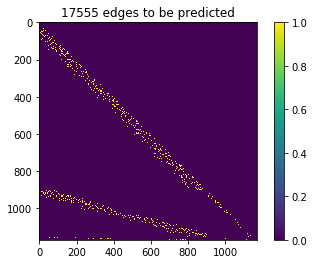

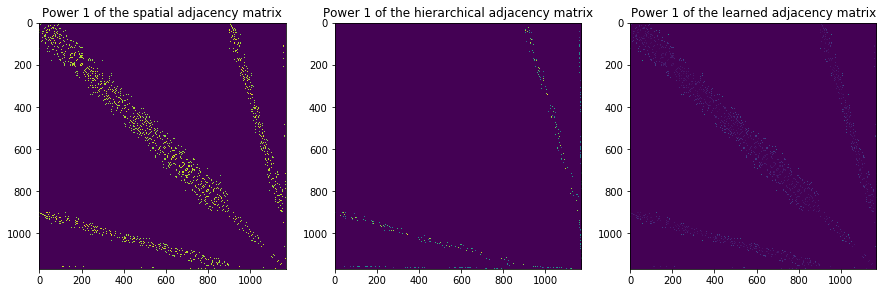

predictions for 20 classes: torch.Size([1, 20])


In [14]:
model = LearnableGNN(n_relations=3, neigborhood_ratio=0.2, K=1)
print(model)
print('number of trainable params: %d' % num_params(model))
data = [torch.from_numpy(np.concatenate((np.concatenate(coord_multiscale), 
                                         np.concatenate(avg_values_multiscale)), axis=1)).unsqueeze(0).float(), 
        torch.from_numpy(np.stack((A_spatial_multiscale, A_hier), axis=2)).unsqueeze(0).float(), False]
predictions = model(data)
print('predictions for %d classes:' % predictions.shape[1], predictions.shape)

## 5.3. Improvement #3 - Multiscale GNN

33% on PASCAL

LearnableGNN(
  (graph_layers): Sequential(
    (0): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=45, out_features=32, bias=True)
        (1): BatchNorm1d_GNN(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (1): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=288, out_features=64, bias=True)
        (1): BatchNorm1d_GNN(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (2): GraphLayer(
      (fc): Sequential(
        (0): Linear(in_features=576, out_features=512, bias=True)
        (1): BatchNorm1d_GNN(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
  )
  (pred_edge): LearnableGraph(
    (pred_edge): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=32, out_features=1, bias=True)


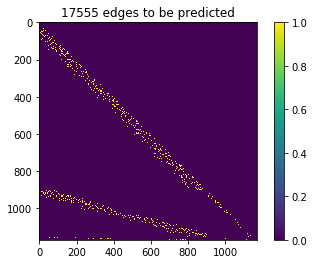

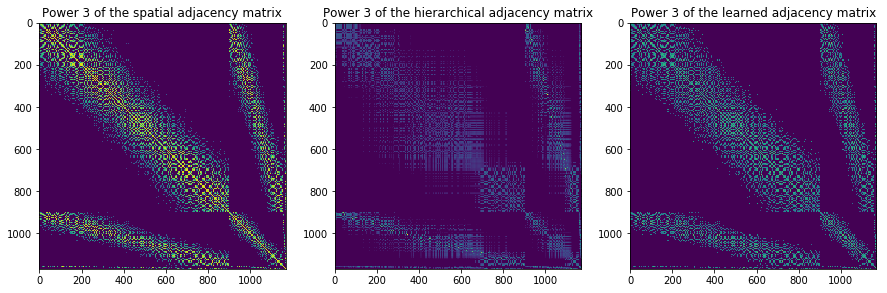

predictions for 20 classes: torch.Size([1, 20])


In [15]:
# Same as above, but just increase K
model = LearnableGNN(n_relations=3, neigborhood_ratio=0.2, K=3)
print(model)
print('number of trainable params: %d' % num_params(model))
data = [torch.from_numpy(np.concatenate((np.concatenate(coord_multiscale), 
                                         np.concatenate(avg_values_multiscale)), axis=1)).unsqueeze(0).float(), 
        torch.from_numpy(np.stack((A_spatial_multiscale, A_hier), axis=2)).unsqueeze(0).float(), False]
predictions = model(data)
print('predictions for %d classes:' % predictions.shape[1], predictions.shape)

## 5.4. Improvement #4 - Relation fusion methods

34.46% on PASCAL

In [16]:
class GraphLayerFusion(GraphLayer):
    def __init__(self,
                 in_features,
                 out_features,
                 K,
                 fusion='pc',
                 n_hidden=64,
                 bnorm=True,
                 activation=nn.ReLU(True),
                 n_relations=1):
        super(GraphLayerFusion, self).__init__(in_features, out_features, K, bnorm, activation, n_relations)
        self.fusion = fusion
        if self.fusion == 'cp':
            fc = [nn.Linear(in_features * K * n_relations, n_hidden), 
                  nn.ReLU(True), 
                  nn.Linear(n_hidden, out_features)]
        else:
            if self.fusion == 'pc':
                fc = [nn.Linear(n_hidden * n_relations, out_features)]
            elif self.fusion == 'sum':
                fc = [nn.Linear(n_hidden, out_features)]
            else:
                raise NotImplementedError('cp, pc or sum is expected. Use GraphLayer for the baseline concatenation fusion')
            self.proj = nn.ModuleList([nn.Sequential(nn.Linear(in_features * K, n_hidden), nn.Tanh()) 
                                       for rel in range(n_relations)])  # projection layers followed by nonlinearity
        if bnorm:
            fc.append(BatchNorm1d_GNN(out_features))
        if activation is not None:
            fc.append(activation)
        self.fc = nn.Sequential(*fc)

    def relation_fusion(self, x, A):
        B, N = x.shape[:2]
        for rel in range(self.n_relations):
            y = self.chebyshev_basis(A[:, :, :, rel], x, self.K).view(B, N, -1)  # B,N,K,C
            if self.fusion in ['pc', 'sum']:
                y = self.proj[rel](y)  # projection 
                if self.fusion == 'sum':
                    y_out = y if rel == 0 else y_out + y
                    continue
            # for CP and PC
            if rel == 0:
                y_out = []
            y_out.append(y)  
        
        y = self.fc(y_out if self.fusion == 'sum' else (torch.cat(y_out, 2)))  # B,N,F
        return y

Relation fusion: SUM
number of trainable params: 109877


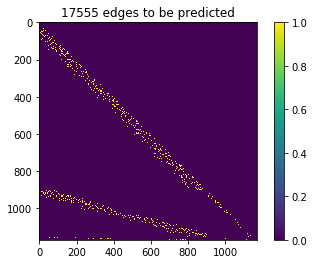

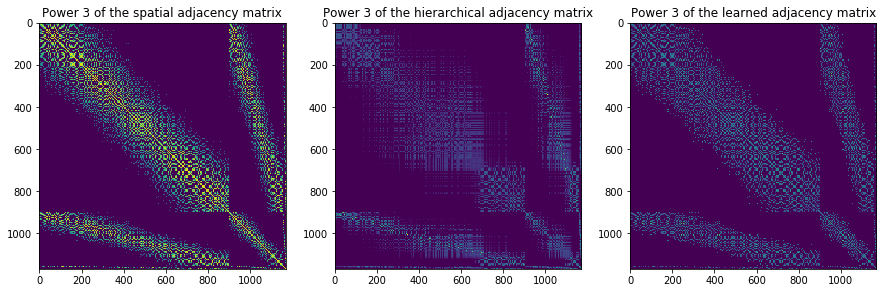

predictions for 20 classes: torch.Size([1, 20])
Relation fusion: CP
number of trainable params: 109493


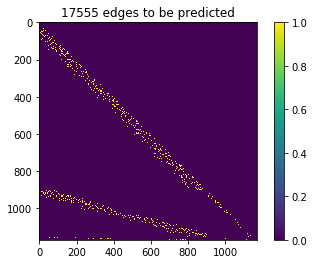

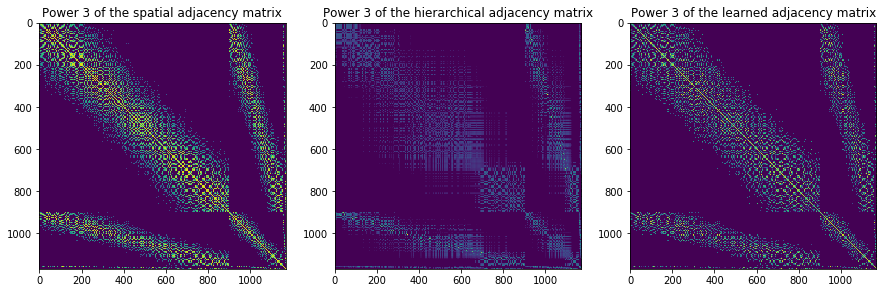

predictions for 20 classes: torch.Size([1, 20])
Relation fusion: PC
number of trainable params: 187701


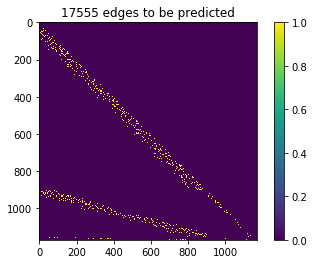

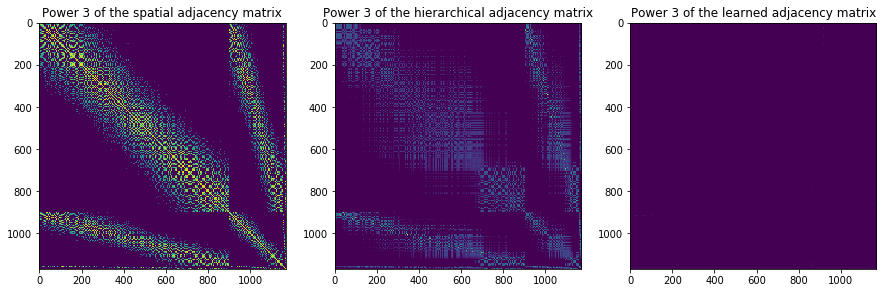

predictions for 20 classes: torch.Size([1, 20])


In [17]:
for fusion in ['sum', 'cp', 'pc']:
    print('Relation fusion: %s' % fusion.upper())
    graph_layer = lambda n_in, f, K, n_relations: GraphLayerFusion(n_in, f, K, n_relations=n_relations, fusion=fusion)
    model = LearnableGNN(n_relations=3, neigborhood_ratio=0.2, K=3, graph_layer=graph_layer)
    #print(model)
    print('number of trainable params: %d' % num_params(model))
    data = [torch.from_numpy(np.concatenate((np.concatenate(coord_multiscale), 
                                             np.concatenate(avg_values_multiscale)), axis=1)).unsqueeze(0).float(), 
            torch.from_numpy(np.stack((A_spatial_multiscale, A_hier), axis=2)).unsqueeze(0).float(), False]
    predictions = model(data)
    print('predictions for %d classes:' % predictions.shape[1], predictions.shape)